# Combining the power of PyTorch and NiftyNet

[NiftyNet](https://niftynet.io/) is "an open source convolutional neural networks platform for medical image analysis and image-guided therapy" built on top of [TensorFlow](https://www.tensorflow.org/). It is probably the easiest way to get started with deep learning for medical image.

[PyTorch](https://pytorch.org/) is "an open source deep learning platform that provides a seamless path from research prototyping to production deployment". It's low-level enough to offer a lot of control over what's going on under the hood during training, and its [dynamic computational graph](https://medium.com/intuitionmachine/pytorch-dynamic-computational-graphs-and-modular-deep-learning-7e7f89f18d1) allows for very easy debugging. Being a generic deep learning framework, it's not tailored to the needs of the medical image field, although its popularity in this field is increasing rapidly.

One can [extend a NiftyNet application](https://niftynet.readthedocs.io/en/dev/extending_app.html), but it's not straightforward without being quite familiar with the framework and fluent in TensorFlow 1.X. Therefore it is convenient to implement applications in PyTorch using NiftyNet models and functionalities. This can be specially used for further experimenting with the model or for transfer learning applications.

So why not use [both](https://www.youtube.com/watch?v=vqgSO8_cRio&feature=youtu.be&t=5)? This tutorial shows how to port the parameters of a model trained on NiftyNet to a PyTorch model and test the PyTorch model while using NiftyNet's I/O modules, which specialize in medical image processing.

## HighRes3DNet

<img src="https://niftynet.io/img/niftynet-logo.png" alt="drawing" width="150"/>

Althought NiftyNet supports different applications, it has mostly been used for segmentation.

***Image segmentation using deep learning*** were the 5 most common words in all full paper titles from *both* [MICCAI 2018](https://www.miccai2018.org/en/) and [MIDL 2019](https://2019.midl.io/), which shows the interest of the community in the topic.

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">&quot;Image segmentation using deep learning&quot;, guess this is the hottest topic in MIDL <a href="https://twitter.com/hashtag/MIDL2019?src=hash&amp;ref_src=twsrc%5Etfw">#MIDL2019</a> <a href="https://twitter.com/midl_conference?ref_src=twsrc%5Etfw">@midl_conference</a> <a href="https://t.co/64smdMjnxY">pic.twitter.com/64smdMjnxY</a></p>&mdash; Hua Ma (@forever_pippo) <a href="https://twitter.com/forever_pippo/status/1148329951550197760?ref_src=twsrc%5Etfw">July 8, 2019</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Just like <a href="https://twitter.com/hashtag/miccai2018?src=hash&amp;ref_src=twsrc%5Etfw">#miccai2018</a>! <a href="https://t.co/3ZTHxj9iPT">pic.twitter.com/3ZTHxj9iPT</a></p>&mdash; Julia Schnabel (@ja_schnabel) <a href="https://twitter.com/ja_schnabel/status/1148356705916526592?ref_src=twsrc%5Etfw">July 8, 2019</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

HighRes3DNet is a residual convolutional neural network architecture designed to have a large receptive field and preserve a high resolution using a relatively small number of parameters. It was presented in 2017 by Li et al. at IPMI: [*On the Compactness, Efficiency, and Representation of 3D Convolutional Networks: Brain Parcellation as a Pretext Task*](https://arxiv.org/abs/1707.01992).

<img src="https://github.com/fepegar/tf2pt/raw/master/images/network.png" alt="HighRes3DNet" width="600"/>

The authors used NiftyNet to train a model based on this architecture to perform [brain parcellation](https://ieeexplore.ieee.org/document/7086081?arnumber=7086081) from $T_1$-weighted MR images using the [ADNI dataset](http://adni.loni.usc.edu/).

These are some qualitative results from the paper:

<img src="https://github.com/fepegar/tf2pt/raw/master/images/li-000.png" alt="Input MRI"/>
<img src="https://github.com/fepegar/tf2pt/raw/master/images/li-001.png" alt="Output parcellation"/>





The code of the architecture is on [NiftyNet GitHub repository](https://github.com/NifTK/NiftyNet/blob/dev/niftynet/network/highres3dnet.py) and the authors have uploaded the parameters and configuration file to the [Model Zoo](https://github.com/NifTK/NiftyNetModelZoo/tree/5-reorganising-with-lfs/highres3dnet_brain_parcellation). After reading the paper and the code, it is relatively straightforward to [implement the same architecture using PyTorch](https://github.com/fepegar/highresnet).

## Contents

In this notebook we will:

1. [Extract the parameters from a TensorFlow checkpoint](https://colab.research.google.com/drive/1vqDojKuC4Svb97LdoEyZQygm3jccX4hr#scrollTo=svG_jtqn0KGU)
2. [Transform them to PyTorch](#PyTorch-world)
3. [Apply the model to a test MRI](#Run-inference)



## Running the notebook

### Online

If you have a Google account, the best way to run this notebook seamlessly is using [Google Colab](https://colab.research.google.com/drive/1vqDojKuC4Svb97LdoEyZQygm3jccX4hr). You'll need to click on "Open in playground", at the top left:

![Playground mode screenshot](https://github.com/fepegar/miccai-educational-challenge-2019/raw/master/images/playground.png)

You'll also get a couple of warnings that you can safely ignore. The first one warns about this notebook not being authored by Google and the second one asks for confirmation to reset all runtimes. These are valid points, but won't affect this tutorial.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1vqDojKuC4Svb97LdoEyZQygm3jccX4hr)

---

Please [report any issues on GitHub](https://github.com/fepegar/miccai-educational-challenge-2019/issues/new) and I'll fix them. You can also [drop me an email](mailto:fernando.perez.garcia.17@ucl.ac.uk?subject=Combining%20the%20power%20of%20PyTorch%20and%20NiftyNet) if you have any questions or comments.



### Locally

To write this notebook I used Ubuntu 18.04 installed on an Alienware 13 R3 laptop, which includes a 6-GB GeForce GTX 1060 NVIDIA GPU. I'm using CUDA 9.0.

Inference using PyTorch took 5725 MB of GPU memory. TensorFlow usually takes as much as possible beforehand.

To run this notebook locally, I recommend downloading the repository and creating a [`conda`](https://docs.conda.io/en/latest/miniconda.html) environment:

```shell
git clone https://github.com/fepegar/miccai-educational-challenge-2019.git
cd miccai-educational-challenge-2019
conda create -n mec2019 python=3.6 -y
conda activate mec2019 && conda install jupyterlab -y && jupyter lab
```

### nbviewer

An already executed version of the notebook can be rendered using [nbviewer](https://nbviewer.jupyter.org/github/fepegar/miccai-educational-challenge-2019/blob/master/Combining_the_power_of_PyTorch_and_NiftyNet.ipynb?flush_cache=true).

<a href="https://nbviewer.jupyter.org/github/fepegar/miccai-educational-challenge-2019/blob/master/Combining_the_power_of_PyTorch_and_NiftyNet.ipynb?flush_cache=true" 
   target="_parent">
   <img src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.png" 
      width="109" height="20">
</a>

## Setup

### Install and import libraries

Clone NiftyNet and some custom Python libraries for this notebook:

In [0]:
%%capture --no-stderr
# This might take about 30 seconds
!rm -rf NiftyNet && git clone https://github.com/NifTK/NiftyNet
!pip install -r NiftyNet/requirements-gpu.txt
!curl -O https://raw.githubusercontent.com/fepegar/miccai-educational-challenge-2019/master/requirements.txt
!curl -O https://raw.githubusercontent.com/fepegar/miccai-educational-challenge-2019/master/tf2pt.py
!curl -O https://raw.githubusercontent.com/fepegar/miccai-educational-challenge-2019/master/utils.py
!curl -O https://raw.githubusercontent.com/fepegar/miccai-educational-challenge-2019/master/visualization.py
!curl -O https://raw.githubusercontent.com/fepegar/highresnet/master/GIFNiftyNet.ctbl
!pip install -r requirements.txt
!pip install --upgrade numpy
import sys
sys.path.insert(0, 'NiftyNet')

In [0]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import os
import tempfile
from pathlib import Path
from configparser import ConfigParser

import numpy as np
import pandas as pd

try:
    # Fancy rendering of Pandas tables
    import google.colab.data_table
    %load_ext google.colab.data_table
    print("We're on Google Colab")
except ModuleNotFoundError:
    print("We're not on Google Colab")
    pd.set_option('display.max_colwidth', -1)  # do not truncate strings when displaying data frames
    pd.set_option('display.max_rows', None)    # show all rows

import torch

from highresnet import HighRes3DNet

We're on Google Colab


In [0]:
%%capture
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import tf2pt
import utils
import visualization

from niftynet.io.image_reader import ImageReader
from niftynet.engine.sampler_grid_v2 import GridSampler
from niftynet.engine.windows_aggregator_grid import GridSamplesAggregator
from niftynet.layer.pad import PadLayer
from niftynet.layer.binary_masking import BinaryMaskingLayer
from niftynet.layer.histogram_normalisation import HistogramNormalisationLayer
from niftynet.layer.mean_variance_normalisation import MeanVarNormalisationLayer

### Download NiftyNet data

We can use NiftyNet's `net_download` to get all we need from the corresponding [Model Zoo entry](https://github.com/NifTK/NiftyNetModelZoo/tree/5-reorganising-with-lfs/highres3dnet_brain_parcellation#downloading-model-zoo-files):

In [0]:
%%capture
%run NiftyNet/net_download.py highres3dnet_brain_parcellation_model_zoo

In [0]:
niftynet_dir = Path('~/niftynet').expanduser()
utils.list_files(niftynet_dir)

niftynet/
    extensions/
        __init__.py
        network/
            __init__.py
        highres3dnet_brain_parcellation/
            highres3dnet_config_eval.ini
            __init__.py
    models/
        highres3dnet_brain_parcellation/
            databrain_std_hist_models_otsu.txt
            Modality0.csv
            settings_inference.txt
            inference_niftynet_log
            parcellation_output/
                inferred.csv
                window_seg_OAS1_0145_MR2_mpr_n4_anon_sbj_111__niftynet_out.nii.gz
            logs/
            models/
                model.ckpt-33000.index
                model.ckpt-33000.data-00000-of-00001
                model.ckpt-33000.meta
    data/
        OASIS/
            OAS1_0145_MR2_mpr_n4_anon_sbj_111.nii.gz
            license


There are three directories under `~/niftynet`:
1. `extensions` is a Python package and contains the [configuration file](https://niftynet.readthedocs.io/en/dev/config_spec.html)
2. `models` contains the landmarks for [histogram standardization](https://ieeexplore.ieee.org/document/836373) (an MRI preprocessing step) and the network parameters
3. `data` contains an [OASIS](https://www.oasis-brains.org/) MRI sample that can be used to test the model.

In [0]:
models_dir = niftynet_dir / 'models'
zoo_entry = 'highres3dnet_brain_parcellation'
checkpoint_name = 'model.ckpt-33000'
checkpoint_path = models_dir / zoo_entry / 'models' / checkpoint_name
data_dir = niftynet_dir / 'data' / 'OASIS'
config_path = niftynet_dir / 'extensions' / zoo_entry / 'highres3dnet_config_eval.ini'
histogram_landmarks_path = models_dir / zoo_entry / 'databrain_std_hist_models_otsu.txt'
tempdir = Path(tempfile.gettempdir()) / 'miccai_niftynet_pytorch'
tempdir.mkdir(exist_ok=True)
csv_tf_path = tempdir / 'variables_tf.csv'
state_dict_tf_path = tempdir / 'state_dict_tf.pth'
state_dict_pt_path = tempdir / 'state_dict_pt.pth'
prediction_pt_dir = tempdir / 'prediction'
prediction_pt_dir.mkdir(exist_ok=True)
color_table_path = 'GIFNiftyNet.ctbl'

Note that the path to the checkpoint isn't really a path to an existing filename, but the basename of the three checkpoint files.

## Transfer the parameters

### TensorFlow world 

<img src="https://static.nvidiagrid.net/ngc/containers/tensorflow.png" alt="drawing" width="50"/>

Let's see what variables are stored in the checkpoint. The following are filtered out by `tf2pt.checkpoint_to_state_dict()` for clarity:
* Variables used by the Adam optimizer during training
* Variables with no shape. They won't help much.
* Variables containing `biased` or `ExponentialMovingAverage`. I have experimented with them and the results using these variables turned out to be different to the ones generated by NiftyNet.

We'll store the variables names in a data frame to list them in this notebook and the values in a Python dictionary to retrieve them later. I figured out the code in `tf2pt.checkpoint_to_state_dict` reading the corresponding [TensorFlow docs](https://www.tensorflow.org/api_docs/python/tf/train/list_variables) and [Stack Overflow answers](https://stackoverflow.com/search?q=restore+tensorflow).

In [0]:
%%capture
tf2pt.checkpoint_to_state_dict(checkpoint_path, csv_tf_path, state_dict_tf_path)
data_frame_tf = pd.read_csv(csv_tf_path)
state_dict_tf = torch.load(state_dict_tf_path)

In [0]:
data_frame_tf

,Unnamed: 0,name,shape
0,0,conv_0_bn_relu/bn_/beta,16
1,1,conv_0_bn_relu/bn_/gamma,16
2,2,conv_0_bn_relu/bn_/moving_mean,16
3,3,conv_0_bn_relu/bn_/moving_variance,16
4,4,conv_0_bn_relu/conv_/w,"3, 3, 3, 1, 16"
5,5,conv_1_bn_relu/bn_/beta,80
6,6,conv_1_bn_relu/bn_/gamma,80
7,7,conv_1_bn_relu/bn_/moving_mean,80
8,8,conv_1_bn_relu/bn_/moving_variance,80
9,9,conv_1_bn_relu/conv_/w,"1, 1, 1, 64, 80"


The shape of the weights of each convolutional kernel represents the three spatial dimensions, the input channels and the output channels: $(Depth, Height, Width, Channels_{in}, Channels_{out})$. Calling the spatial dimensions *depth*, *height* and *width* doesn't make a lot of sense when dealing with 3D medical images, but we'll keep this computer vision notation as it's consistent with the documentation of both PyTorch and TensorFlow.

The layers names and parameters shapes are coherent overall with the figure in the paper, but there's an additional $1 \times 1 \times 1$ convolutional layer with 80 output channels, which is also in the [code](https://github.com/NifTK/NiftyNet/blob/1832a516c909b67d0d9618acbd04a7642c12efca/niftynet/network/highres3dnet.py#L93). It seems to be the model with [dropout](http://jmlr.org/papers/v15/srivastava14a.html) used in the study to compute the model's uncertainty, so [our implementation of the architecture](https://github.com/fepegar/highresnet/blob/f434266a51924681f95b01a0f03611fbf1148db6/highresnet/highresnet.py#L82-L97) should include this layer as well.

There are three [dilation](https://arxiv.org/abs/1511.07122) blocks composed of three [residual](https://arxiv.org/abs/1512.03385) blocks each, which have two convolutional layers inside. That's $3 \times 3 \times 2 = 18$ layers. The other three conv layers are the initial convolution before the first residual block, the one before the dropout and the classifier at the end. Apparently, *all* the convolutional layers have an associated [batch normalization]((https://arxiv.org/abs/1502.03167)) layer, which differs from the figure in the paper. That makes 21 convolutional layers and 21 batch normalization layers whose parameters must be transferred.

Each batch norm layer contains 4 parameter groups: *moving mean* $\mathrm{E}[x]$, *variance* $\mathrm{Var}[x]$ and the affine transformation parameters $\gamma$ (scale or *weight*) and $\beta$ (shift or *bias*):

\begin{align}
y = \frac{x - \mathrm{E}[x]}{\sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta
\end{align}

Therefore the total number of parameter groups is $21 + 21 \times 4 = 105$. The convolutional layers don't use a bias parameter, as it's not necessary when using batch norm.

### PyTorch world

<img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2019/01/pytorch-logo.png" alt="drawing" width="100"/>


To match the model in the paper, we set the number of classes to 160 and enable the flag to add the dropout layer.

In [0]:
num_input_modalities = 1
num_classes = 160
model = HighRes3DNet(num_input_modalities, num_classes, add_dropout_layer=True)

Let's see what the variable names created by PyTorch are:

In [0]:
state_dict_pt = model.state_dict()
rows = []
for name, parameters in state_dict_pt.items():
    if 'num_batches_tracked' in name:  # filter out for clarity
        continue
    shape = ', '.join(str(n) for n in parameters.shape)
    row = {'name': name, 'shape': shape}
    rows.append(row)
df_pt = pd.DataFrame.from_dict(rows)
df_pt

,name,shape
0,block.0.convolutional_block.1.weight,"16, 1, 3, 3, 3"
1,block.0.convolutional_block.2.weight,16
2,block.0.convolutional_block.2.bias,16
3,block.0.convolutional_block.2.running_mean,16
4,block.0.convolutional_block.2.running_var,16
5,block.1.dilation_block.0.residual_block.0.conv...,16
6,block.1.dilation_block.0.residual_block.0.conv...,16
7,block.1.dilation_block.0.residual_block.0.conv...,16
8,block.1.dilation_block.0.residual_block.0.conv...,16
9,block.1.dilation_block.0.residual_block.0.conv...,"16, 16, 3, 3, 3"


We can see that `moving_mean` and `moving_variance` are called `running_mean` and `running_var` in PyTorch. Also, $\gamma$ and $\beta$ are called `weight` and `bias`.

The convolutional kernels have a different arrangement: $(Channels_{out}, Channels_{in}, Depth, Height, Width)$.

The names and shapes look consistent between both implementations and there are 105 lines in both lists, so we should be able to create a mapping between the TensorFlow and the PyTorch variables. The function `tf2pt.tf2pt()` receives a TensorFlow-like variable and returns the corresponding PyTorch-like variable.

In [0]:
for name_tf, tensor_tf in state_dict_tf.items():
    shape_tf = tuple(tensor_tf.shape)
    print(f'{str(shape_tf):18}', name_tf) 
    
    # Convert TensorFlow name to PyTorch name
    name_pt, tensor_pt = tf2pt.tf2pt(name_tf, tensor_tf)
    
    shape_pt = tuple(state_dict_pt[name_pt].shape)
    print(f'{str(shape_pt):18}', name_pt)
    
    # Sanity check
    if sum(shape_tf) != sum(shape_pt):
        raise ValueError
       
    # Add weights to PyTorch state dictionary
    state_dict_pt[name_pt] = tensor_pt
    print()
torch.save(state_dict_pt, state_dict_pt_path)
print('State dictionary saved to', state_dict_pt_path)

(16,)              conv_0_bn_relu/bn_/beta
(16,)              block.0.convolutional_block.2.bias

(16,)              conv_0_bn_relu/bn_/gamma
(16,)              block.0.convolutional_block.2.weight

(16,)              conv_0_bn_relu/bn_/moving_mean
(16,)              block.0.convolutional_block.2.running_mean

(16,)              conv_0_bn_relu/bn_/moving_variance
(16,)              block.0.convolutional_block.2.running_var

(3, 3, 3, 1, 16)   conv_0_bn_relu/conv_/w
(16, 1, 3, 3, 3)   block.0.convolutional_block.1.weight

(80,)              conv_1_bn_relu/bn_/beta
(80,)              block.4.convolutional_block.1.bias

(80,)              conv_1_bn_relu/bn_/gamma
(80,)              block.4.convolutional_block.1.weight

(80,)              conv_1_bn_relu/bn_/moving_mean
(80,)              block.4.convolutional_block.1.running_mean

(80,)              conv_1_bn_relu/bn_/moving_variance
(80,)              block.4.convolutional_block.1.running_var

(1, 1, 1, 64, 80)  conv_1_bn_relu/conv_/w
(80

If PyTorch is happy when loading our state dict into the model, we should be on the right track 🤞...

In [0]:
model.load_state_dict(state_dict_pt)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

No incompatible keys. Yay! 🎉

### Plot weights

Something great about PyTorch is that the modules parameters are easily accesible. Let's plot some of them before and after training:

In [0]:
model_initial = HighRes3DNet(num_input_modalities, num_classes, add_dropout_layer=True)
model_pretrained = model

By [default](https://github.com/pytorch/pytorch/blob/77353636de32a207cf0a332395f91011bc2f07fb/torch/nn/modules/conv.py#L48-L53), convolutional layers in PyTorch are initialized using [He uniform variance scaling](https://arxiv.org/abs/1502.01852):

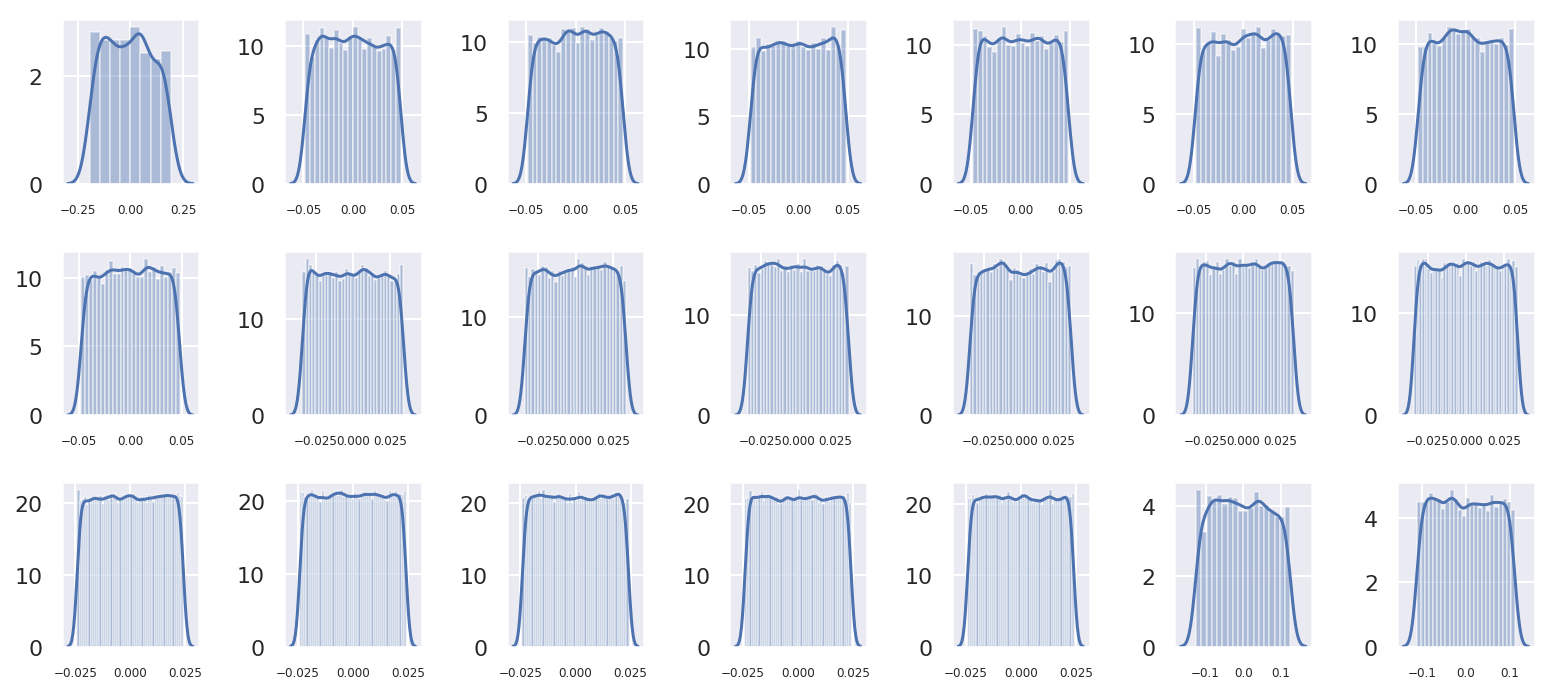

In [0]:
visualization.plot_all_parameters(model_initial)

And this is what they look like after training:

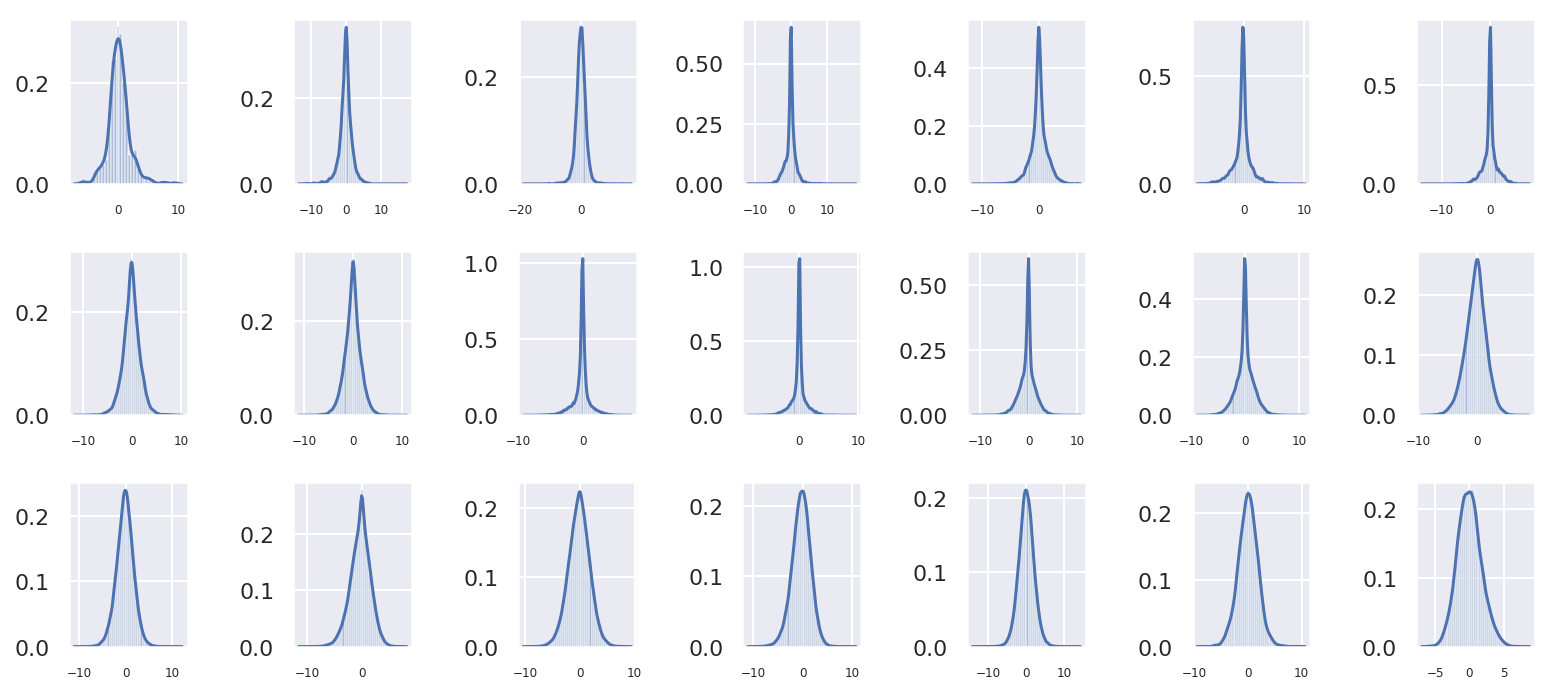

In [0]:
visualization.plot_all_parameters(model_pretrained)

## Run inference

The last step is to test the PyTorch model and verify that results are consistent with NiftyNet.

### Configuration file

We need to match the configuration used during training in order to obtain consistent results. This are the relevant contents of the downloaded [configuration file](https://niftynet.readthedocs.io/en/dev/config_spec.html):

```ini
[Modality0]
path_to_search = data/OASIS/
filename_contains = nii
pixdim = (1.0, 1.0, 1.0)
axcodes = (R, A, S)

[NETWORK]
name = highres3dnet
volume_padding_size = 10
whitening = True
normalisation = True
normalise_foreground_only=True
foreground_type = mean_plus
histogram_ref_file = databrain_std_hist_models_otsu.txt
cutoff = (0.001, 0.999)

[INFERENCE]
border = 2
spatial_window_size = (128, 128, 128)
```

In [0]:
config = ConfigParser()
config.read(config_path);

### Reader

We can figure out the necessary preprocessing by reading the [paper](https://arxiv.org/abs/1707.01992), the [code](https://github.com/NifTK/NiftyNet/blob/61f2a8bbac1348591412c00f55d1c19b91c0367f/niftynet/application/segmentation_application.py#L95-L192) and the [configuration file](https://niftynet.readthedocs.io/en/dev/config_spec.html) that was downloaded. NiftyNet offers some powerful I/O tools. We will use readers, samplers and aggregators to read, preprocess and write all the files. Some of the [demos](https://github.com/NifTK/NiftyNet/tree/dev/demos/module_examples) show how they can be used.

In [0]:
%%capture
input_dict = dict(
    path_to_search=str(data_dir),
    filename_contains='nii',
    axcodes=('R', 'A', 'S'),
    pixdim=(1, 1, 1),
)
data_parameters = {
    'image': input_dict,
}
reader = ImageReader().initialise(data_parameters)

In [0]:
_, image_data_dict, _ = reader()
original_image = image_data_dict['image']
original_image.shape

(160, 256, 256, 1, 1)

Looking at the shape of our image and knowing that the reader reoriented it into [RAS+ orientation](http://www.grahamwideman.com/gw/brain/orientation/orientterms.htm), we can see that it represents $160$ sagittal slices of $256 \times 256$ pixels, with $1$ channel (monomodal) and $1$ time point. Let's see what it looks like:

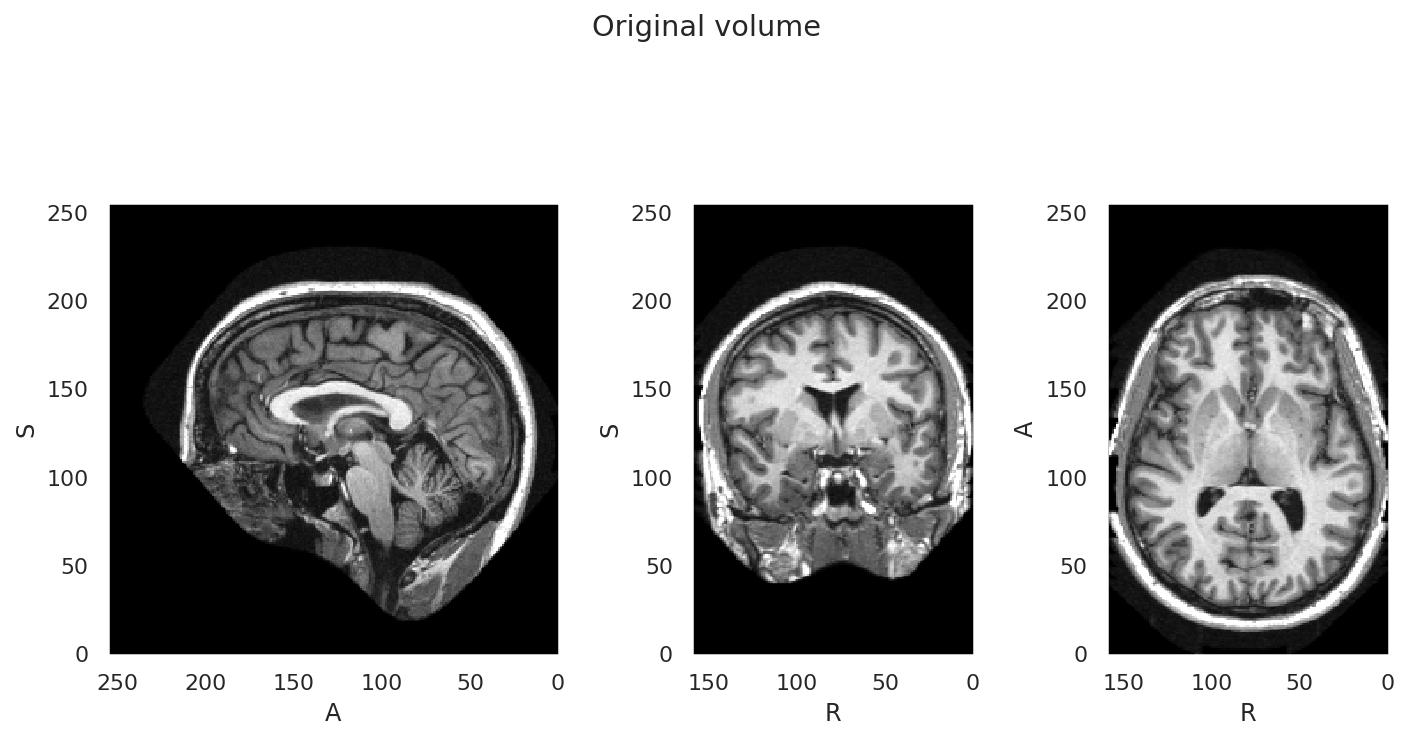

In [0]:
visualization.plot_volume(original_image, title='Original volume')

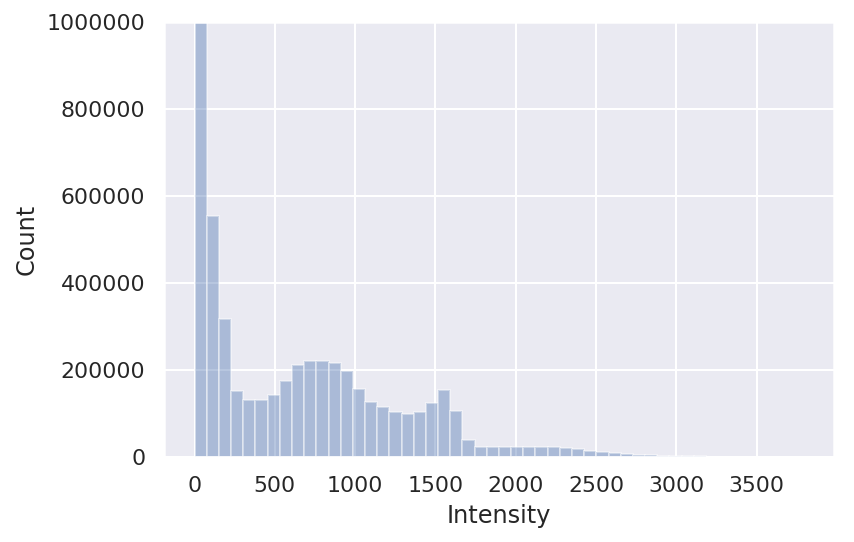

In [0]:
visualization.plot_histogram(original_image, kde=False, labels=True, ylim=(0, 1e6))

### Preprocessing

We [pad the input volume](https://niftynet.readthedocs.io/en/dev/window_sizes.html#volume-padding-size) and crop the output volume to reduce the border effect introduced by the padded convolutions:

In [0]:
volume_padding_layer = PadLayer(
    image_name=['image'],  # https://github.com/NifTK/NiftyNet/blob/61f2a8bbac1348591412c00f55d1c19b91c0367f/niftynet/layer/pad.py#L52
    border=(10, 10, 10),
)

We use a masking function in order to use only the foreground voxels for normalization:

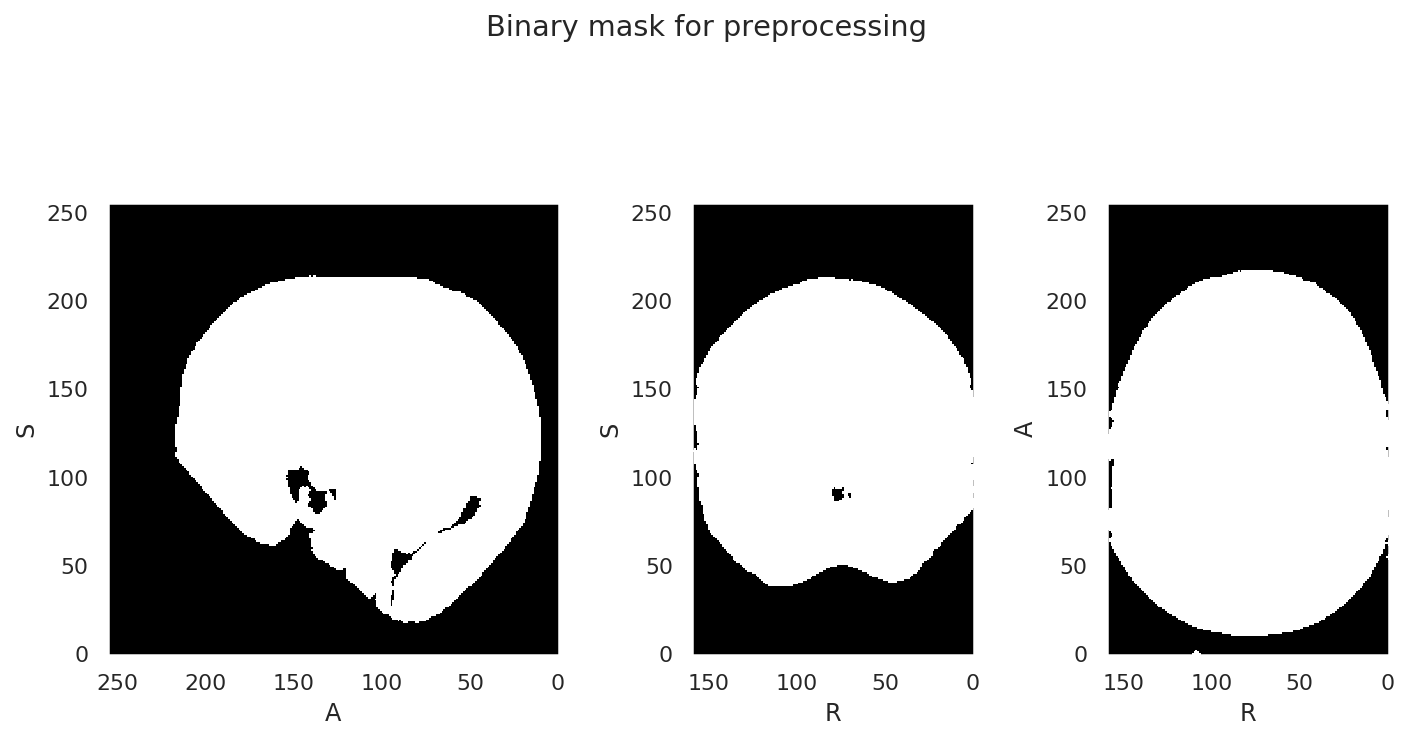

In [0]:
binary_masking_func = BinaryMaskingLayer(type_str=config['NETWORK']['foreground_type'])
mask = binary_masking_func(original_image)
visualization.plot_volume(mask, enhance=False, title='Binary mask for preprocessing')

We use [MRI histogram standardization](https://ieeexplore.ieee.org/document/836373) trained on the training dataset for our test image. We use the mean intensity of the volume as a threshold for the mask, as the authors of the method claim that this usually gives good results.

In [0]:
hist_norm = HistogramNormalisationLayer(
    image_name='image',
    modalities=['Modality0'],
    model_filename=str(histogram_landmarks_path),
    binary_masking_func=binary_masking_func,
    cutoff=(0.001, 0.999),
    name='hist_norm_layer',
)

Finally, we force our image foreground to have zero mean and unit variance:

In [0]:
whitening = MeanVarNormalisationLayer(
    image_name='image', binary_masking_func=binary_masking_func)

Here's our preprocessed image:

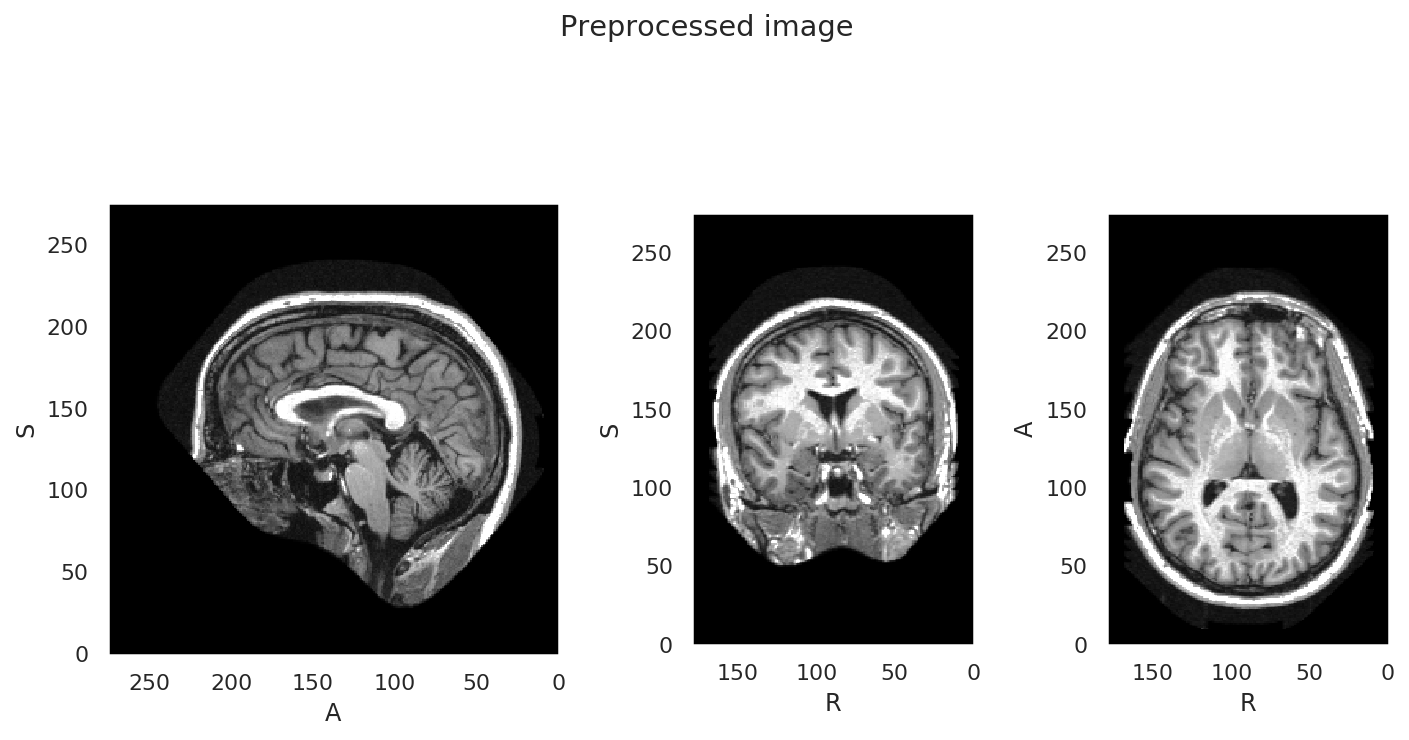

In [0]:
%%capture --no-display
preprocessing_layers = [
    volume_padding_layer,
    hist_norm,
    whitening,
]
reader = ImageReader().initialise(data_parameters)
reader.add_preprocessing_layers(preprocessing_layers)
_, image_data_dict, _ = reader()
preprocessed_image = image_data_dict['image']
visualization.plot_volume(preprocessed_image, title='Preprocessed image')

Note the small difference of intensities due to histogram standardization and the 10-voxel zero-padding.

We can clearly see the effect of the whitening layer on the histogram:

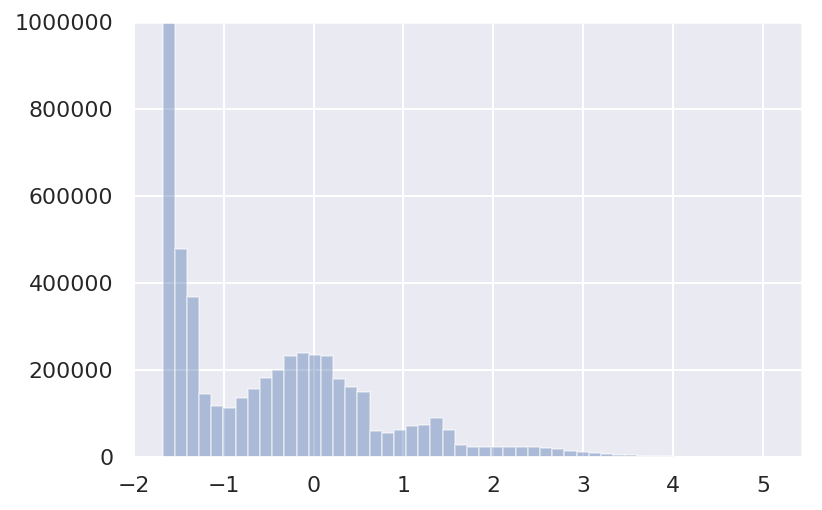

In [0]:
visualization.plot_histogram(preprocessed_image, kde=False, ylim=(0, 1e6))

### Sampler and aggregator

As the whole image doesn't fit in most GPUs, we need to use a [patch-based](https://niftynet.readthedocs.io/en/dev/window_sizes.html) approach.

<img src="https://github.com/fepegar/tf2pt/raw/master/images/patch.png" alt="drawing" width="600"/>

We'll use NiftyNet's grid sampler to get all windows from the volume (blue in the previous image) and a grid samples aggregator (red) to reconstruct the output image from the inferred windows. If you have any memory issues, try reducing the window size.

The [window border](https://niftynet.readthedocs.io/en/dev/window_sizes.html#border) is needed to reduce the border effect in a dense prediction.

In [0]:
%%capture
window_size = 128
window_size = 3 * (window_size, )
window_border = 2, 2, 2
window_size_dict = {'image': window_size}
batch_size = 1

sampler = GridSampler(
    reader,
    window_size_dict,
    window_border=window_border,
)

prediction_pt_dir = tempdir / 'prediction'
prediction_pt_dir.mkdir(exist_ok=True)
aggregator = GridSamplesAggregator(
    image_reader=reader,
    window_border=window_border,
    output_path=prediction_pt_dir,
)

Now, the most important part: running the parcellation! We'll iterate over the windows provided by the grid sampler, pass them through the network and aggregate them to the output volume (this might take a couple of minutes):

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
model.to(device)
model.eval()
for batch_index, batch_dict in enumerate(sampler()):
    print(f'Running inference iteration {batch_index}...')
    input_tensor = tf2pt.niftynet_batch_to_torch_tensor(batch_dict).to(device)
    with torch.no_grad():
        logits = model(input_tensor)
    labels = tf2pt.torch_logits_to_niftynet_labels(logits)
    window_dict = dict(window=labels)
    aggregator.decode_batch(window_dict, batch_dict['image_location'])

# Release GPU memory
del model
del model_pretrained
del input_tensor
del logits
torch.cuda.empty_cache()

I0726 17:15:18.269147 140434843858816 sampler_grid_v2.py:77] grid sampling image sizes: {'image': (180, 276, 276, 1, 1)}
I0726 17:15:18.270517 140434843858816 sampler_grid_v2.py:79] grid sampling window sizes: {'image': (128, 128, 128, 1, 1)}
I0726 17:15:18.271709 140434843858816 sampler_grid_v2.py:87] yielding 27 locations from image


Running inference iteration 0...
Running inference iteration 1...
Running inference iteration 2...
Running inference iteration 3...
Running inference iteration 4...
Running inference iteration 5...
Running inference iteration 6...
Running inference iteration 7...
Running inference iteration 8...
Running inference iteration 9...
Running inference iteration 10...
Running inference iteration 11...
Running inference iteration 12...
Running inference iteration 13...
Running inference iteration 14...
Running inference iteration 15...
Running inference iteration 16...
Running inference iteration 17...
Running inference iteration 18...
Running inference iteration 19...
Running inference iteration 20...
Running inference iteration 21...
Running inference iteration 22...
Running inference iteration 23...
Running inference iteration 24...
Running inference iteration 25...
Running inference iteration 26...
Running inference iteration 27...


W0726 17:21:03.963805 140434843858816 misc_io.py:392] File /tmp/miccai_niftynet_pytorch/prediction/window_OAS1_0145_MR2_mpr_n4_anon_sbj_111_niftynet_out.nii.gz exists, overwriting the file.
I0726 17:21:04.133769 140434843858816 misc_io.py:397] Saved /tmp/miccai_niftynet_pytorch/prediction/window_OAS1_0145_MR2_mpr_n4_anon_sbj_111_niftynet_out.nii.gz


Let's [run the inference using NiftyNet](https://github.com/NifTK/NiftyNetModelZoo/tree/5-reorganising-with-lfs/highres3dnet_brain_parcellation#generating-segmentations-for-example-data) as well, so that we can compare both results (this step will also take a couple of minutes):

In [0]:
%run NiftyNet/net_segment.py inference -c ~/niftynet/extensions/highres3dnet_brain_parcellation/highres3dnet_config_eval.ini

NiftyNet version 0.5.0+170.g1cfefe6a
[CUSTOM]
-- num_classes: 160
-- output_prob: False
-- label_normalisation: False
-- softmax: True
-- min_sampling_ratio: 0
-- compulsory_labels: (0, 1)
-- rand_samples: 0
-- min_numb_labels: 1
-- proba_connect: True
-- evaluation_units: foreground
-- image: ('Modality0',)
-- inferred: ()
-- weight: ()
-- sampler: ()
-- label: ()
-- name: net_segment
[CONFIG_FILE]
-- path: /root/niftynet/extensions/highres3dnet_brain_parcellation/highres3dnet_config_eval.ini
[MODALITY0]
-- csv_file: 
-- path_to_search: data/OASIS/
-- filename_contains: ('nii',)
-- filename_not_contains: ()
-- filename_removefromid: 
-- interp_order: 0
-- loader: None
-- pixdim: (1.0, 1.0, 1.0)
-- axcodes: ('R', 'A', 'S')
-- spatial_window_size: (96, 96, 96)
[SYSTEM]
-- cuda_devices: ""
-- num_threads: 2
-- num_gpus: 1
-- model_dir: /root/niftynet/models/highres3dnet_brain_parcellation
-- dataset_split_file: ./dataset_split.csv
-- event_handler: ('model_saver', 'model_restorer', 'samp

I0726 17:21:05.590726 140434843858816 segmentation_application.py:43] starting segmentation application


INFO:niftynet: `csv_file = ` not found, writing to "/root/niftynet/models/highres3dnet_brain_parcellation/Modality0.csv" instead.


I0726 17:21:05.604069 140434843858816 image_sets_partitioner.py:266] `csv_file = ` not found, writing to "/root/niftynet/models/highres3dnet_brain_parcellation/Modality0.csv" instead.


INFO:niftynet: Overwriting existing: "/root/niftynet/models/highres3dnet_brain_parcellation/Modality0.csv".


I0726 17:21:05.611155 140434843858816 image_sets_partitioner.py:269] Overwriting existing: "/root/niftynet/models/highres3dnet_brain_parcellation/Modality0.csv".


INFO:niftynet: [Modality0] search file folders, writing csv file /root/niftynet/models/highres3dnet_brain_parcellation/Modality0.csv


I0726 17:21:05.617348 140434843858816 image_sets_partitioner.py:286] [Modality0] search file folders, writing csv file /root/niftynet/models/highres3dnet_brain_parcellation/Modality0.csv


INFO:niftynet: 

Number of subjects 1, input section names: ['subject_id', 'Modality0']
-- using all subjects (without data partitioning).



I0726 17:21:05.632365 140434843858816 image_sets_partitioner.py:90] 

Number of subjects 1, input section names: ['subject_id', 'Modality0']
-- using all subjects (without data partitioning).



INFO:niftynet: Image reader: loading 1 subjects from sections ('Modality0',) as input [image]


I0726 17:21:05.653702 140434843858816 image_reader.py:178] Image reader: loading 1 subjects from sections ('Modality0',) as input [image]


INFO:niftynet: normalisation histogram reference models ready for image:('Modality0',)


I0726 17:21:05.663030 140434843858816 histogram_normalisation.py:109] normalisation histogram reference models ready for image:('Modality0',)


INFO:niftynet: initialised window instance


I0726 17:21:05.723920 140434843858816 sampler_grid_v2.py:53] initialised window instance


INFO:niftynet: initialised grid sampler {'image': (1, 128, 128, 128, 1, 1), 'image_location': (1, 7)}


I0726 17:21:05.728496 140434843858816 sampler_grid_v2.py:54] initialised grid sampler {'image': (1, 128, 128, 128, 1, 1), 'image_location': (1, 7)}


INFO:niftynet: using HighRes3DNet


I0726 17:21:05.753723 140434843858816 base_net.py:29] using HighRes3DNet


W0726 17:21:05.759899 140434843858816 deprecation_wrapper.py:119] From NiftyNet/niftynet/application/base_application.py:203: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



INFO:niftynet: Initialising dataset from generator...


I0726 17:21:05.777676 140434843858816 image_window_dataset.py:318] Initialising dataset from generator...


W0726 17:21:05.881535 140434843858816 deprecation_wrapper.py:119] From NiftyNet/niftynet/layer/convolution.py:89: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.



W0726 17:21:05.975831 140434843858816 deprecation_wrapper.py:119] From NiftyNet/niftynet/layer/bn.py:75: The name tf.add_to_collection is deprecated. Please use tf.compat.v1.add_to_collection instead.



W0726 17:21:08.037356 140434843858816 deprecation_wrapper.py:119] From NiftyNet/niftynet/engine/application_variables.py:188: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.



W0726 17:21:08.046461 140434843858816 deprecation_wrapper.py:119] From NiftyNet/niftynet/engine/handler_model.py:108: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.



INFO:niftynet: Restoring parameters from /root/niftynet/models/highres3dnet_brain_parcellation/models/model.ckpt-33000


I0726 17:21:08.249189 140434843858816 saver.py:1280] Restoring parameters from /root/niftynet/models/highres3dnet_brain_parcellation/models/model.ckpt-33000


INFO:niftynet: grid sampling image sizes: {'image': (180, 276, 276, 1, 1)}


I0726 17:21:11.744683 140430021007104 sampler_grid_v2.py:77] grid sampling image sizes: {'image': (180, 276, 276, 1, 1)}


INFO:niftynet: grid sampling window sizes: {'image': (128, 128, 128, 1, 1)}


I0726 17:21:11.748336 140430021007104 sampler_grid_v2.py:79] grid sampling window sizes: {'image': (128, 128, 128, 1, 1)}


INFO:niftynet: yielding 27 locations from image


I0726 17:21:11.751874 140430021007104 sampler_grid_v2.py:87] yielding 27 locations from image


INFO:niftynet: inference iter 0,  (10.474950s)


I0726 17:21:19.663286 140434843858816 handler_console.py:40] inference iter 0,  (10.474950s)


INFO:niftynet: inference iter 1,  (3.121657s)


I0726 17:21:23.007887 140434843858816 handler_console.py:40] inference iter 1,  (3.121657s)


INFO:niftynet: inference iter 2,  (3.120006s)


I0726 17:21:26.140871 140434843858816 handler_console.py:40] inference iter 2,  (3.120006s)


INFO:niftynet: inference iter 3,  (3.118142s)


I0726 17:21:29.266869 140434843858816 handler_console.py:40] inference iter 3,  (3.118142s)


INFO:niftynet: inference iter 4,  (3.116725s)


I0726 17:21:32.396432 140434843858816 handler_console.py:40] inference iter 4,  (3.116725s)


INFO:niftynet: inference iter 5,  (3.125822s)


I0726 17:21:35.529693 140434843858816 handler_console.py:40] inference iter 5,  (3.125822s)


INFO:niftynet: inference iter 6,  (3.112741s)


I0726 17:21:38.654363 140434843858816 handler_console.py:40] inference iter 6,  (3.112741s)


INFO:niftynet: inference iter 7,  (3.120792s)


I0726 17:21:41.786410 140434843858816 handler_console.py:40] inference iter 7,  (3.120792s)


INFO:niftynet: inference iter 8,  (3.110467s)


I0726 17:21:44.908570 140434843858816 handler_console.py:40] inference iter 8,  (3.110467s)


INFO:niftynet: inference iter 9,  (3.108045s)


I0726 17:21:48.024250 140434843858816 handler_console.py:40] inference iter 9,  (3.108045s)


INFO:niftynet: inference iter 10,  (3.111046s)


I0726 17:21:51.146508 140434843858816 handler_console.py:40] inference iter 10,  (3.111046s)


INFO:niftynet: inference iter 11,  (3.105626s)


I0726 17:21:54.263196 140434843858816 handler_console.py:40] inference iter 11,  (3.105626s)


INFO:niftynet: inference iter 12,  (3.118913s)


I0726 17:21:57.389497 140434843858816 handler_console.py:40] inference iter 12,  (3.118913s)


INFO:niftynet: inference iter 13,  (3.110383s)


I0726 17:22:00.510126 140434843858816 handler_console.py:40] inference iter 13,  (3.110383s)


INFO:niftynet: inference iter 14,  (3.114095s)


I0726 17:22:03.636257 140434843858816 handler_console.py:40] inference iter 14,  (3.114095s)


INFO:niftynet: inference iter 15,  (3.102098s)


I0726 17:22:06.752891 140434843858816 handler_console.py:40] inference iter 15,  (3.102098s)


INFO:niftynet: inference iter 16,  (3.107651s)


I0726 17:22:09.872266 140434843858816 handler_console.py:40] inference iter 16,  (3.107651s)


INFO:niftynet: inference iter 17,  (3.106219s)


I0726 17:22:12.989797 140434843858816 handler_console.py:40] inference iter 17,  (3.106219s)


INFO:niftynet: inference iter 18,  (3.105126s)


I0726 17:22:16.101722 140434843858816 handler_console.py:40] inference iter 18,  (3.105126s)


INFO:niftynet: inference iter 19,  (3.100845s)


I0726 17:22:19.214961 140434843858816 handler_console.py:40] inference iter 19,  (3.100845s)


INFO:niftynet: inference iter 20,  (3.109529s)


I0726 17:22:22.334461 140434843858816 handler_console.py:40] inference iter 20,  (3.109529s)


INFO:niftynet: inference iter 21,  (3.104449s)


I0726 17:22:25.449559 140434843858816 handler_console.py:40] inference iter 21,  (3.104449s)


INFO:niftynet: inference iter 22,  (3.111564s)


I0726 17:22:28.568587 140434843858816 handler_console.py:40] inference iter 22,  (3.111564s)


INFO:niftynet: inference iter 23,  (3.099362s)


I0726 17:22:31.679299 140434843858816 handler_console.py:40] inference iter 23,  (3.099362s)


INFO:niftynet: inference iter 24,  (3.101085s)


I0726 17:22:34.787712 140434843858816 handler_console.py:40] inference iter 24,  (3.101085s)


INFO:niftynet: inference iter 25,  (3.096122s)


I0726 17:22:37.898203 140434843858816 handler_console.py:40] inference iter 25,  (3.096122s)


INFO:niftynet: inference iter 26,  (3.099012s)


I0726 17:22:41.003927 140434843858816 handler_console.py:40] inference iter 26,  (3.099012s)


INFO:niftynet: inference iter 27,  (3.098265s)


I0726 17:22:44.108803 140434843858816 handler_console.py:40] inference iter 27,  (3.098265s)


W0726 17:22:44.118392 140434843858816 misc_io.py:392] File /root/niftynet/models/highres3dnet_brain_parcellation/parcellation_output/window_seg_OAS1_0145_MR2_mpr_n4_anon_sbj_111__niftynet_out.nii.gz exists, overwriting the file.


INFO:niftynet: Saved /root/niftynet/models/highres3dnet_brain_parcellation/parcellation_output/window_seg_OAS1_0145_MR2_mpr_n4_anon_sbj_111__niftynet_out.nii.gz


I0726 17:22:44.415358 140434843858816 misc_io.py:397] Saved /root/niftynet/models/highres3dnet_brain_parcellation/parcellation_output/window_seg_OAS1_0145_MR2_mpr_n4_anon_sbj_111__niftynet_out.nii.gz


INFO:niftynet: stopping -- event handler: OutputInterpreter.


I0726 17:22:44.418990 140434843858816 application_driver.py:336] stopping -- event handler: OutputInterpreter.


INFO:niftynet: cleaning up...


I0726 17:22:44.426174 140434843858816 application_driver.py:220] cleaning up...


INFO:niftynet: stopping sampling threads


I0726 17:22:44.430626 140434843858816 handler_sampler.py:53] stopping sampling threads


INFO:niftynet: SegmentationApplication stopped (time in second 96.42).


I0726 17:22:44.462320 140434843858816 application_driver.py:232] SegmentationApplication stopped (time in second 96.42).


<Figure size 432x288 with 0 Axes>

## Check results

In [0]:
%%capture
input_image = utils.get_first_array(data_dir)
labels_nn = utils.get_first_array(models_dir).astype(np.uint16)
labels_pt = utils.get_first_array(prediction_pt_dir).astype(np.uint16)

### Quantitatively

In [0]:
difference = labels_nn != labels_pt
num_different_voxels = np.count_nonzero(difference)
print('Number of different voxels:', num_different_voxels)

Number of different voxels: 0


Success! ✨ Both parcellations are exactly the same.

### Qualitatively

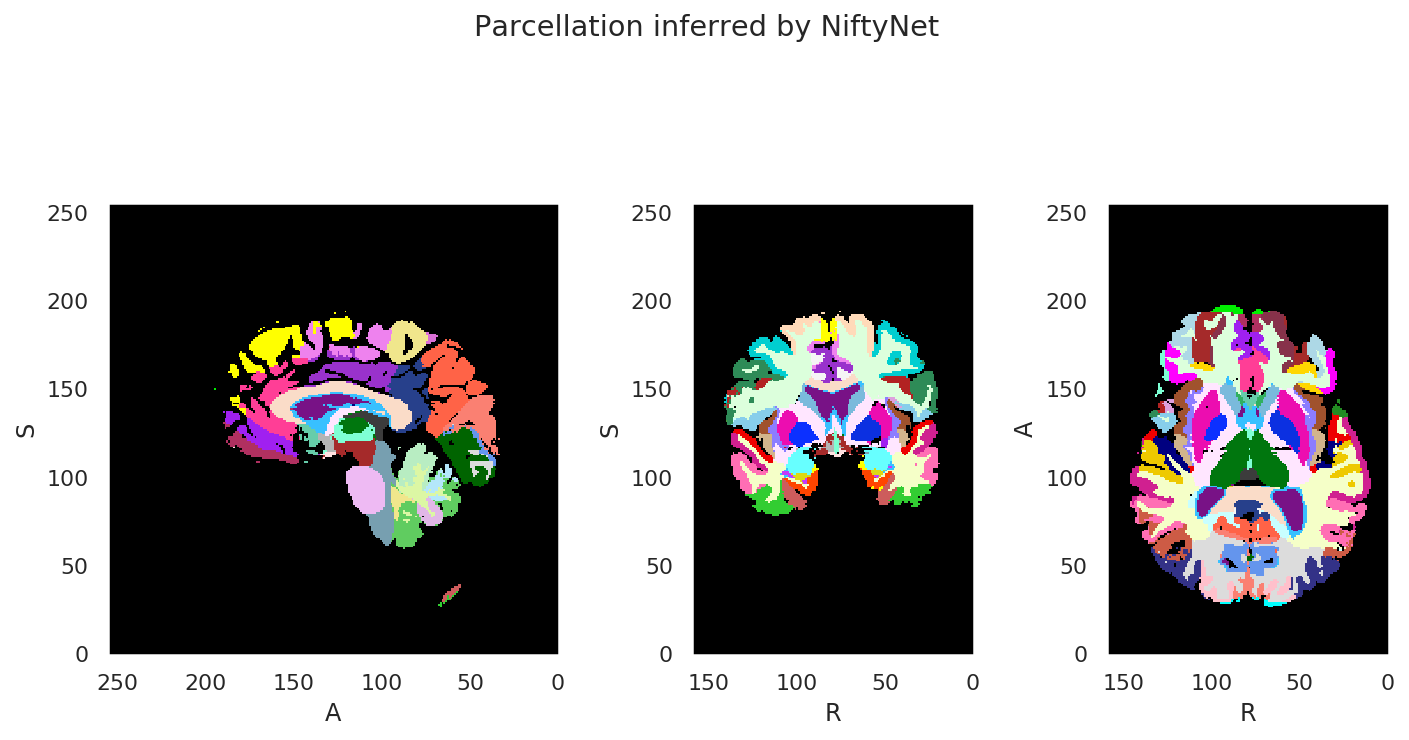

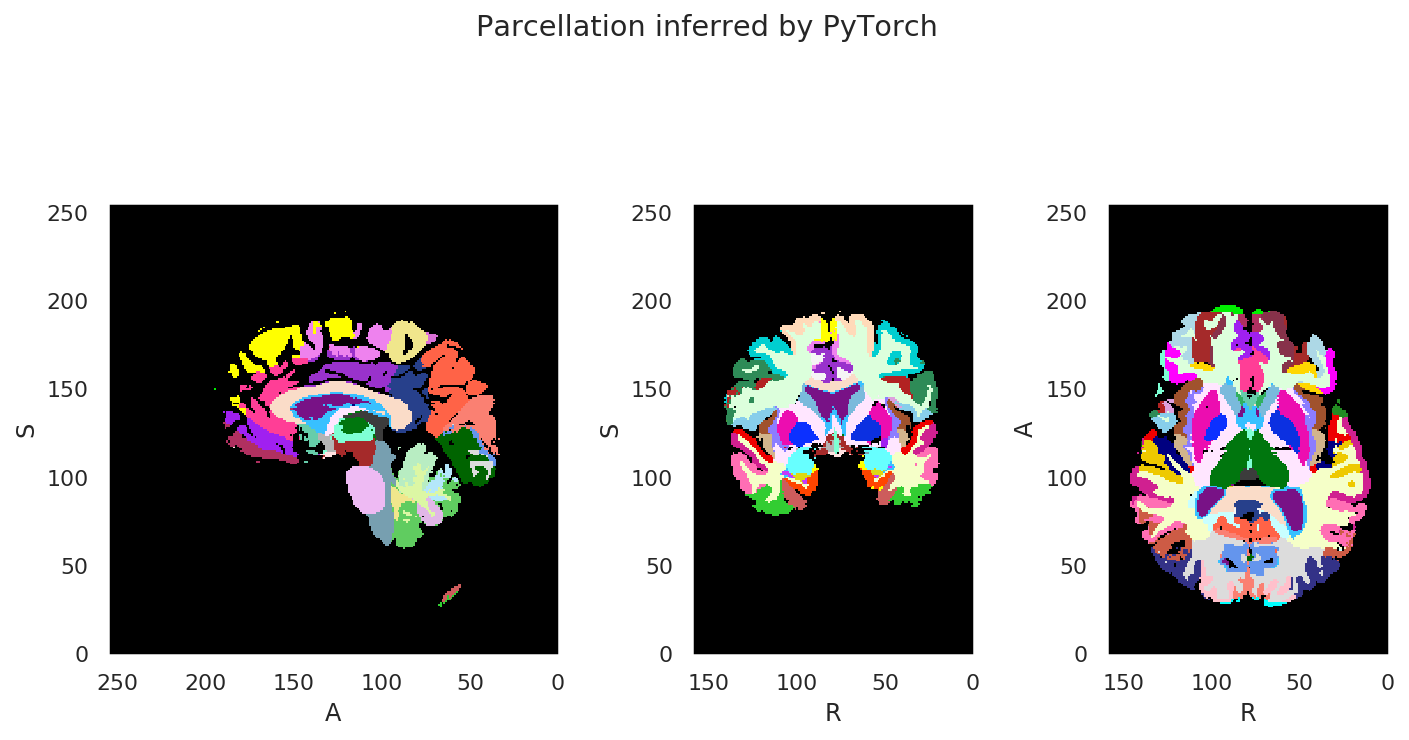

In [0]:
visualization.plot_volume(
    labels_nn,
    enhance=False,
    colors_path=color_table_path,
    title='Parcellation inferred by NiftyNet',
)
visualization.plot_volume(
    labels_pt,
    enhance=False,
    colors_path=color_table_path,
    title='Parcellation inferred by PyTorch',
)

## Conclusion

In this tutorial we have shown how to combine features from two deep learning frameworks, NiftyNet and PyTorch.

We ported a model for brain parcellation from NiftyNet to PyTorch and ran an inference using PyTorch model and NiftyNet I/O capabilities.

## Acknowledgments

If you want to cite this tutorial you can use this Zenodo DOI:

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.3352316.svg)](https://doi.org/10.5281/zenodo.3352316)